## Toy model of correlations with gain variation by row
## Craig Lage - 04May20

In [1]:
import os, sys, glob, time, copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def buildFlats(nx, ny, numFluxes, flux0, gain0, dgain, mode, BF=False, BF01=2E-7, BF10=1E-7, BF11=5E-8):
    # Build the flats
    flats = []
    for n in range(numFluxes):
        flux = flux0 * (n + 1) # In electrons
        for m in range(2):  # Pairs
            arr = np.zeros([nx, ny])
            for j in range(ny):
                if mode == 'Deterministic':
                    gain = gain0 * (1.0 + float(j)/float(ny) * dgain) # Deterministic gain variation
                elif mode == 'Random':
                    gain = gain0 * (1.0 + (-1.0 + 2.0 * np.random.rand()) / 2.0 * dgain) # Random gain variation
                for i in range(nx):
                    arr[i,j] = np.random.poisson(lam=flux) / gain # in ADU
            if BF:
                # Apply a toy BF - only 10, 01, and 11 terms
                arr_delta = np.zeros_like(arr)
                for j in range(ny-1):
                    for i in range(nx-1):
                        excess = arr[i,j] * gain0 - flux # In electrons
                        delta01 = BF01 * flux * excess
                        arr_delta[i,j] -= delta01
                        arr_delta[i,j+1] += delta01
                        delta10 = BF10 * flux * excess
                        arr_delta[i,j] -= delta10
                        arr_delta[i+1,j] += delta10
                        delta11 = BF11 * flux * excess
                        arr_delta[i,j] -= delta11
                        arr_delta[i+1,j+1] += delta11
                arr = arr + arr_delta / gain # In ADU
            flats.append(arr)
    return flats

In [3]:
# Copied from DM makeBrighterFatterKernel.py 
# but made modifications to eliminate need for DM stack
def crossCorrelate(flat1, flat2, maxLag, border, subRowMean=False):
    mean = np.mean(flat1[border: -border, border: -border])
    mean += np.mean(flat2[border: -border, border: -border])
    # Diff the images, and apply border
    diff = copy.deepcopy(flat1)
    diff -= flat2
    if subRowMean: # Follows code from Seth Digel
        mean_arr = np.mean(diff, axis=0)
        for i in range(diff.shape[0]):
            diff[i,:] -= mean_arr
    diff = diff[border: -border, border: -border]

    # Measure the correlations
    dim0 = diff[0: -maxLag,0 : -maxLag]
    dim0 -= np.mean(dim0)
    width, height = dim0.shape
    xcorr = np.zeros((maxLag + 1, maxLag + 1), dtype=np.float64)

    for xlag in range(maxLag + 1):
        for ylag in range(maxLag + 1):
            dim_xy = copy.deepcopy(diff[xlag:xlag + width, ylag: ylag + height])
            #print(xlag, ylag, dim_xy.shape, np.mean(dim_xy))
            dim_xy -= np.mean(dim_xy)
            dim_xy *= dim0
            xcorr[xlag, ylag] = np.mean(dim_xy)

    return xcorr, mean

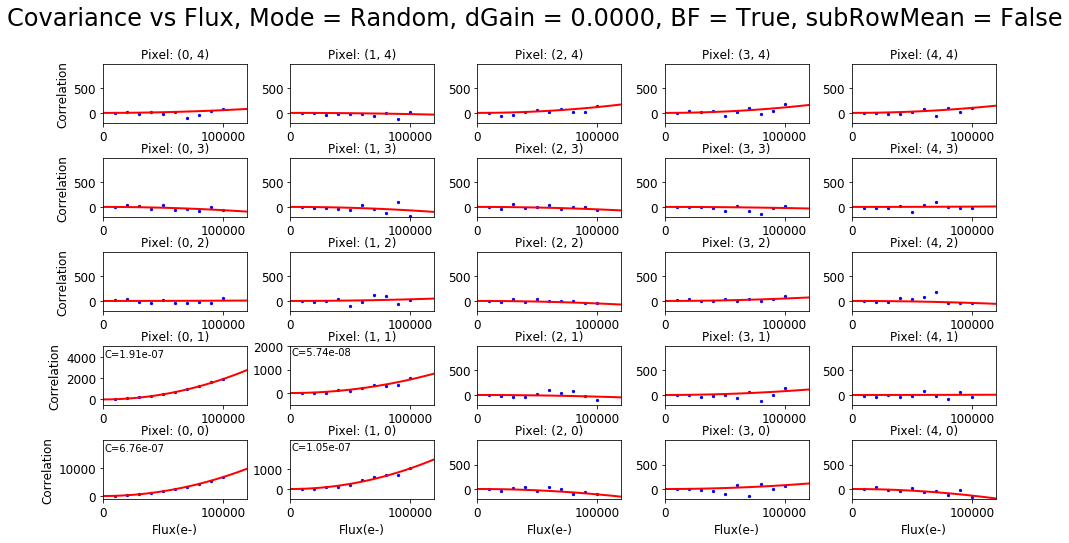

In [4]:
topdir = '/Users/cslage/Research/LSST/code/BOT/R12S02_issue/toy_model/'

nx = 512
ny = 2048
numFluxes = 10
flux0 = 10000
gain0 = 1.52 # Nominal gain
maxLag = 4
border = 10
PlotDelta = maxLag + 1

longRangeCorrs = {} # Dictionary to hold long-range values
BF = True
subRowMean = False
dgains = [0.00]#, 0.001, 0.002, 0.004, 0.008, 0.016]
modes = ['Random']#['Random', 'Deterministic']
for mode in modes:
    for dgain in dgains:
        key = '%s_%03d'%(mode, int(1000*dgain)) # Dictionary key to hold long range values
        flats = buildFlats(nx, ny, numFluxes, flux0, gain0, dgain, mode,BF=BF)
        xcorrs = []
        means = []
        for n in range(numFluxes):
            xcorr, mean = crossCorrelate(flats[2 * n], flats[2 * n + 1], maxLag, border, subRowMean = subRowMean)
            xcorrs.append(xcorr)
            means.append(mean)
        fig = plt.figure(figsize = (16,8))
        plt.suptitle("Covariance vs Flux, Mode = %s, dGain = %.4f, BF = %s, subRowMean = %s"%(mode, dgain, BF, subRowMean), fontsize = 24)
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        plotcounter = 0
        lrCorrs = []
        for jj in range(PlotDelta-1, -1, -1):
            for ii in range(PlotDelta):
                plotcounter += 1
                plt.subplot(PlotDelta, PlotDelta, plotcounter)
                cov = []
                flux = []
                for n in range(numFluxes):
                    xcorr = xcorrs[n][ii, jj] / 2.0 * gain0**2
                    mean = means[n] / 2.0 * gain0
                    if ii == 0 and jj == 0:
                        xcorr -= mean
                        xcorr *= -1.0
                    cov.append(xcorr)
                    flux.append(mean)
                cov = np.array(cov)
                flux = np.array(flux)
                plt.scatter(flux, cov, color='blue', marker='.', s=20)
                coefs = np.polyfit(flux*flux, cov, 1)
                if jj == 0:
                    lrCorrs.append(coefs[0])
                xplot = np.linspace(0,120000, 100)
                yplot = coefs[0]*xplot*xplot
                plt.plot(xplot,yplot, color = 'red', lw = 2)
                plt.title("Pixel: (%d, %d)"%(ii, jj), fontsize = 12)
                if jj == 0:
                    plt.xlabel("Flux(e-)", fontsize = 12)
                if ii == 0:
                    plt.ylabel("Correlation", fontsize = 12)
                    
                plt.xlim(0,120000)
                plt.xticks([0,100000],fontsize = 12)
                if ii == 0 and jj == 0:
                    plt.yticks([0,10000],fontsize = 12)
                    plt.ylim(-1000,20000)
                    plt.text(1000, 16000, "C=%.3g"%(coefs[0]))
                elif ii == 0 and jj == 1:
                    plt.yticks([0,2000,4000],fontsize = 12)
                    plt.ylim(-500,5000)
                    plt.text(1000, 4000, "C=%.3g"%(coefs[0]))
                elif ii == 1 and jj == 0:
                    plt.yticks([0,1000],fontsize = 12)
                    plt.ylim(-500,2500)
                    plt.text(1000, 2000, "C=%.3g"%(coefs[0]))
                elif ii == 1 and jj == 1:
                    plt.yticks([0,1000,2000],fontsize = 12)
                    plt.ylim(-500,2000)
                    plt.text(1000, 1600, "C=%.3g"%(coefs[0]))
                else:
                    plt.yticks([0,500],fontsize = 12)
                    plt.ylim(-200,1000)
        longRangeCorrs[key] = lrCorrs
        #plt.savefig(topdir+'Covariance_vs_Flux_%s_29Apr20.pdf'%key)
        #plt.savefig(topdir+'Covariance_vs_Flux_BF_Random_002_NoRowSub_04May20.pdf')


In [ ]:
fig = plt.figure(figsize = (16,8))
plt.subplots_adjust(wspace=0.3, hspace=0.6)
plotcounter = 0
for mode in modes:
    for plott in ['Log', 'Linear']:
        plotcounter += 1
        plt.subplot(2,2,plotcounter)
        plt.title(mode, fontsize = 24)
        
        for dgain in dgains:
            xs = []
            ys = []
            key = '%s_%03d'%(mode, int(1000*dgain)) # Dictionary key to hold long range values
            lrCorrs = longRangeCorrs[key]
            for ii in range(PlotDelta):
                xs.append(ii)
                ys.append(max(1.0E-9, lrCorrs[ii]))
            if plott == 'Linear':
                plt.plot(xs, np.array(ys)*1.0E7, marker = 'o', label = 'dGain = %.3f'%dgain)
                plt.ylim(-10,250)
                plt.ylabel('Covariance * 1E7')
                if mode == 'Deterministic':
                    plt.legend()
            else:
                plt.plot(xs, np.log10(ys), marker = 'o', label = 'dGain = %.3f'%dgain)
                plt.ylim(-9.0, -4.0)
                plt.ylabel('Log Covariance')
            plt.xlabel('X pixel')
    
#plt.savefig(topdir+'Covariance_vs_dGain_29Apr20.pdf')

In [ ]:
nx = 512
ny = 2048
gain0 = 1.52 # Nominal gain
maxLag = 4
border = 10
PlotDelta = maxLag + 1

flats1 = buildFlats(nx, ny, 1, 20000, gain0, 0.0, "Random2")
flats2 = buildFlats(nx, ny, 1, 20000, gain0, 0.002, "Random2")
print("Sig1 = %f"%np.std(np.mean(flats1[0], axis=0)), "Sig2 = %f"%np.std(np.mean(flats2[0], axis=0)))

In [ ]:
xs = np.arange(2048)
fig = plt.figure(figsize = (16,8))
plt.title("Mean by row", fontsize = 24)
plt.scatter(xs,np.mean(flats1[0], axis=0), label='dgain = 0.000')
plt.scatter(xs,np.mean(flats2[0], axis=0), label='dgain = 0.002')
plt.xlabel("Y pixel", fontsize=18)
plt.ylabel("Row Mean", fontsize=18)
plt.legend()
plt.savefig(topdir+'Row_by_Row_Scatter_29Apr20.png')